In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

# Load dataset
file_path = '/content/drive/MyDrive/Complaints/complaints.csv'
df = pd.read_csv(file_path)

# 1. Check dataset shape
print("="*50)
print(f"Dataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("="*50 + "\n")

# 2. Check basic information
print("Dataset Information:")
print(df.info())
print("\n" + "="*50 + "\n")

# 3. Check distribution of product categories
# First, let's see what the target column is called
print("Column Names:")
print(df.columns.tolist())
print("\n" + "="*50 + "\n")

# created the 'product_category' column:
if 'product_category' in df.columns:
    print("Label Distribution (Product Categories):")
    print(df['product_category'].value_counts())
    print("\n" + "="*50 + "\n")

    # Visualize distribution
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.countplot(x='product_category', data=df)
    plt.title('Distribution of Complaint Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()
else:
    print("Original Product Distribution:")
    print(df['Product'].value_counts() if 'Product' in df.columns else df['product'].value_counts())
    print("\n" + "="*50 + "\n")

# 4. Check for missing values
print("Missing Values per Column:")
print(df.isna().sum())
print("\n" + "="*50 + "\n")

# 5. Additional useful stats
print("Basic Statistics:")
print(df.describe(include='all'))
print("\n" + "="*50 + "\n")

# 6. Check text data quality
if 'consumer_complaint_narrative' in df.columns:
    # Calculate text length
    df['text_length'] = df['consumer_complaint_narrative'].str.len()

    print("Text Length Statistics:")
    print(df['text_length'].describe())

    # Plot text length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'].dropna(), bins=50)
    plt.title('Distribution of Complaint Text Length')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    plt.xlim(0, 5000)
    plt.show()

Dataset Shape: (9358718, 18)
Number of rows: 9358718
Number of columns: 18

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9358718 entries, 0 to 9358717
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?           

Starting processing pipeline...


Reading CSV: 94it [01:14,  1.26it/s]


Data loaded successfully with shape: (9358718, 2)

Class standardization complete:
category
Credit reporting    1881867
Debt collection      330872
Consumer Loan        128465
Mortgage             129518 

Using sample of 100000 records for development

Starting text preprocessing on 100000 records...


Processing batches: 100%|██████████| 2/2 [00:36<00:00, 18.22s/it]


Text preprocessing completed in 36.60 seconds
Class distribution after text cleaning:
category
Credit reporting    76308
Debt collection     13314
Consumer Loan        5149
Mortgage             5181 

Training set class distribution:
category
Credit reporting    53415
Debt collection      9320
Consumer Loan        3604
Mortgage             3627 

Test set class distribution:
category
Credit reporting    22893
Debt collection      3994
Consumer Loan        1545
Mortgage             1554 

Starting vectorization...
Processing Completed!
Training shape: (69966, 5000)
Test shape: (29986, 5000)
Feature dimension: 5000


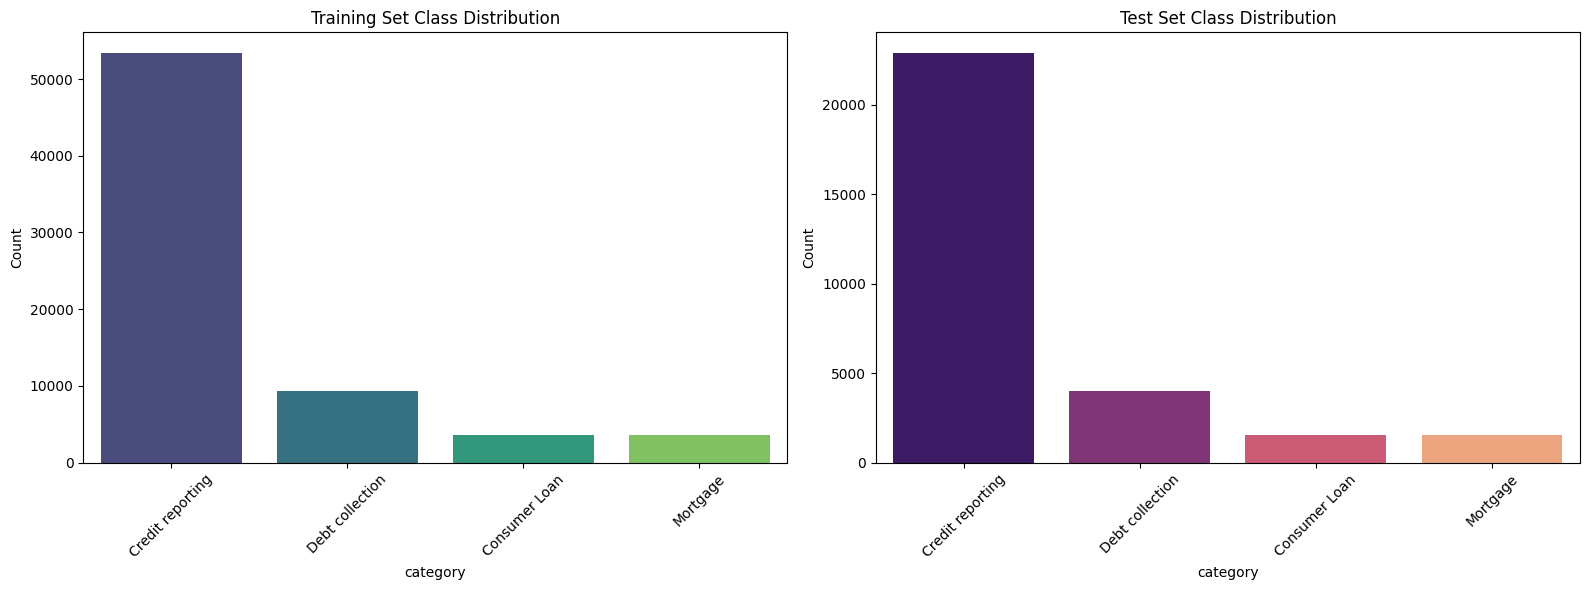


Dataset statistics:
Total cleaned complaints: 99952
Class proportions: 
category
Credit reporting    0.763446
Debt collection     0.133204
Consumer Loan       0.051515
Mortgage            0.051835
Vectorized data saved to /content/drive/MyDrive/Complaints/vectorized_data.npz

Total processing time: 139.31 seconds


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
import pandas as pd
import numpy as np
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm
import time
import os
from scipy.sparse import save_npz

# Download required NLTK resources
nltk.download(['punkt', 'stopwords', 'wordnet'], quiet=True)

# PRE-COMPUTE STOPWORDS AND FINANCIAL TERMS
base_stopwords = set(stopwords.words('english'))
financial_stopwords = {'bank', 'account', 'company', 'information', 'please', 'would',
                       'could', 'also', 'said', 'one', 'two', 'like', 'even', 'get', 'since'}
full_stopwords = base_stopwords.union(financial_stopwords)

financial_mapping = {
    'mortgage': 'mortgag', 'loan': 'loan', 'credit': 'credit', 'debt': 'debt',
    'collector': 'collect', 'report': 'report', 'collection': 'collect',
    'reporting': 'report', 'reported': 'report', 'equifax': 'creditbureau',
    'experian': 'creditbureau', 'transunion': 'creditbureau'
}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Pre-cache lemmatization for common words
lemma_cache = {}

def get_lemma(token):
    """Cached lemmatization for faster processing"""
    if token in lemma_cache:
        return lemma_cache[token]

    lemma = lemmatizer.lemmatize(token, pos='n')
    lemma = lemmatizer.lemmatize(lemma, pos='v')
    lemma_cache[token] = lemma
    return lemma

# Optimized token pattern
token_pattern = re.compile(r'\b\w{3,}\b')

def preprocess_complaint_text(text):
    """Optimized text preprocessing with efficient token handling"""
    if not isinstance(text, str) or len(text.strip()) < 10:
        return ""

    # Text cleaning
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization using regex findall
    tokens = token_pattern.findall(text)

    # Process tokens
    processed_tokens = []
    for token in tokens:
        if token in full_stopwords:
            continue

        # Lemmatize with cache
        lemma = get_lemma(token)

        # Normalize financial terms
        if lemma in financial_mapping:
            lemma = financial_mapping[lemma]

        processed_tokens.append(lemma)

    return ' '.join(processed_tokens)

def process_chunk(chunk):
    """Process a chunk of texts"""
    return [preprocess_complaint_text(text) for text in chunk]

def parallel_preprocess(texts, n_workers=None):
    """Process texts in parallel using multiprocessing with progress tracking"""
    if n_workers is None:
        n_workers = min(4, multiprocessing.cpu_count())

    chunk_size = min(5000, len(texts) // (n_workers * 4) or 1)
    chunks = [texts[i:i + chunk_size] for i in range(0, len(texts), chunk_size)]

    results = []
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(process_chunk, chunk) for chunk in chunks]

        # Process with progress bar
        for future in tqdm(futures, desc="Processing texts", unit="chunk"):
            results.extend(future.result())

    return results

def preprocess_and_vectorize(file_path, test_size=0.3, random_state=42, sample_size=50000):
    """Optimized preprocessing pipeline with parallel processing"""
    # 1. Load data with optimized reading

    chunks = pd.read_csv(file_path, chunksize=100000, usecols=['Product', 'Consumer complaint narrative'])
    df = pd.concat([chunk for chunk in tqdm(chunks, desc="Reading CSV")])
    print(f"Data loaded successfully with shape: {df.shape}\n")

    # 2. Filter and map categories
    df = df.dropna(subset=['Consumer complaint narrative'])

    category_map = {
        'Credit reporting or other personal consumer reports': 0,
        'Credit reporting, credit repair services, or other personal consumer reports': 0,
        'Credit reporting': 0,
        'Debt collection': 1,
        'Consumer Loan': 2,
        'Student loan': 2,
        'Vehicle loan or lease': 2,
        'Payday loan': 2,
        'Payday loan, title loan, or personal loan': 2,
        'Payday loan, title loan, personal loan, or advance loan': 2,
        'Mortgage': 3
    }

    df['category'] = df['Product'].map(category_map)
    df = df.dropna(subset=['category'])
    df['category'] = df['category'].astype(int)

    # 3. Report class distribution
    category_names = {
        0: 'Credit reporting',
        1: 'Debt collection',
        2: 'Consumer Loan',
        3: 'Mortgage'
    }

    print("Class standardization complete:")
    class_dist = df['category'].value_counts().sort_index()
    class_dist.index = class_dist.index.map(category_names)
    print(class_dist.to_string(), "\n")

    # Sampling for development
    if sample_size and sample_size < len(df):
        df = df.sample(sample_size, random_state=random_state)
        print(f"Using sample of {len(df)} records for development\n")

    # 4. Parallel text preprocessing
    print(f"Starting text preprocessing on {len(df)} records...")
    start_time = time.time()

    # Process in batches to reduce memory usage
    batch_size = 50000
    processed_texts = []
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch = df['Consumer complaint narrative'].iloc[i:i+batch_size].tolist()
        processed_texts.extend(parallel_preprocess(batch))

    df['clean_text'] = processed_texts
    df = df[df['clean_text'].str.len() > 10]

    print(f"Text preprocessing completed in {time.time()-start_time:.2f} seconds")

    # Report distribution after cleaning
    cleaned_dist = df['category'].value_counts().sort_index()
    cleaned_dist.index = cleaned_dist.index.map(category_names)
    print("Class distribution after text cleaning:")
    print(cleaned_dist.to_string(), "\n")

    # 5. Train-test split
    X = df['clean_text']
    y = df['category']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Report train/test distribution
    print("Training set class distribution:")
    print(y_train.value_counts().sort_index().rename(index=category_names).to_string(), "\n")

    print("Test set class distribution:")
    print(y_test.value_counts().sort_index().rename(index=category_names).to_string(), "\n")

    # 6. Vectorization
    print("Starting vectorization...")
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        dtype=np.float32
    )

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)


    joblib.dump(tfidf, '/content/drive/MyDrive/Complaints/tfidf_vectorizer.joblib')

    # 7. Prepare final output
    feature_dim = X_train_tfidf.shape[1]
    print("Processing Completed!")
    print(f"Training shape: {X_train_tfidf.shape}")
    print(f"Test shape: {X_test_tfidf.shape}")
    print(f"Feature dimension: {feature_dim}")

    return X_train_tfidf, X_test_tfidf, y_train, y_test, tfidf, df

def visualize_class_distribution(y_train, y_test):
    """Visualize class distributions in train and test sets"""
    # Map numeric categories to names
    category_names = {
        0: 'Credit reporting',
        1: 'Debt collection',
        2: 'Consumer Loan',
        3: 'Mortgage'
    }

    # Prepare data
    train_counts = y_train.value_counts().sort_index()
    test_counts = y_test.value_counts().sort_index()

    train_counts.index = train_counts.index.map(category_names)
    test_counts.index = test_counts.index.map(category_names)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Train distribution
    sns.barplot(x=train_counts.index, y=train_counts.values, ax=ax1, palette="viridis")
    ax1.set_title('Training Set Class Distribution')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    # Test distribution
    sns.barplot(x=test_counts.index, y=test_counts.values, ax=ax2, palette="magma")
    ax2.set_title('Test Set Class Distribution')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":

    # File path
    file_path = '/content/drive/MyDrive/Complaints/complaints.csv'

    # Reduce sample size for faster testing - remove for full processing
    sample_size = 100000

     # Run preprocessing pipeline
    start_time = time.time()
    print("Starting processing pipeline...")
    X_train, X_test, y_train, y_test, vectorizer, full_df = preprocess_and_vectorize(
        file_path,
        test_size=0.3,
        random_state=42,
        sample_size=sample_size
    )

    # Visualize distributions
    visualize_class_distribution(y_train, y_test)

    # Sample output
    print("\nDataset statistics:")
    print(f"Total cleaned complaints: {len(full_df)}")
    print(f"Class proportions: ")
    print(full_df['category'].value_counts(normalize=True).sort_index().rename(index={
        0: 'Credit reporting',
        1: 'Debt collection',
        2: 'Consumer Loan',
        3: 'Mortgage'
    }).to_string())

    # SAVE VECTORIZED DATA
    save_dir = '/content/drive/MyDrive/Complaints/'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'vectorized_data.npz')

    save_npz(save_path.replace('.npz', '_X_train.npz'), X_train)
    save_npz(save_path.replace('.npz', '_X_test.npz'), X_test)
    np.savez(save_path,
             y_train=y_train.values,
             y_test=y_test.values)

    print(f"Vectorized data saved to {save_path}")
    print(f"\nTotal processing time: {time.time()-start_time:.2f} seconds")

Starting class imbalance handling...
Original Class Distribution:
  Mortgage: 3627
  Debt collection: 9320
  Credit reporting: 53415
  Consumer Loan: 3604


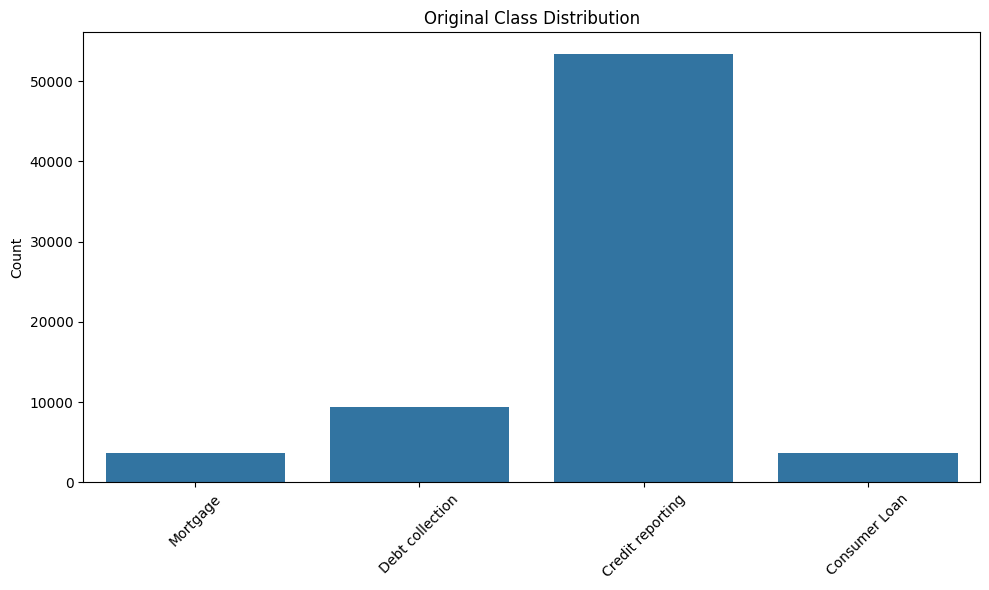


Applying SMOTE for class balancing...

Resampled Class Distribution:
  Mortgage: 20000
  Debt collection: 20000
  Credit reporting: 53415
  Consumer Loan: 20000


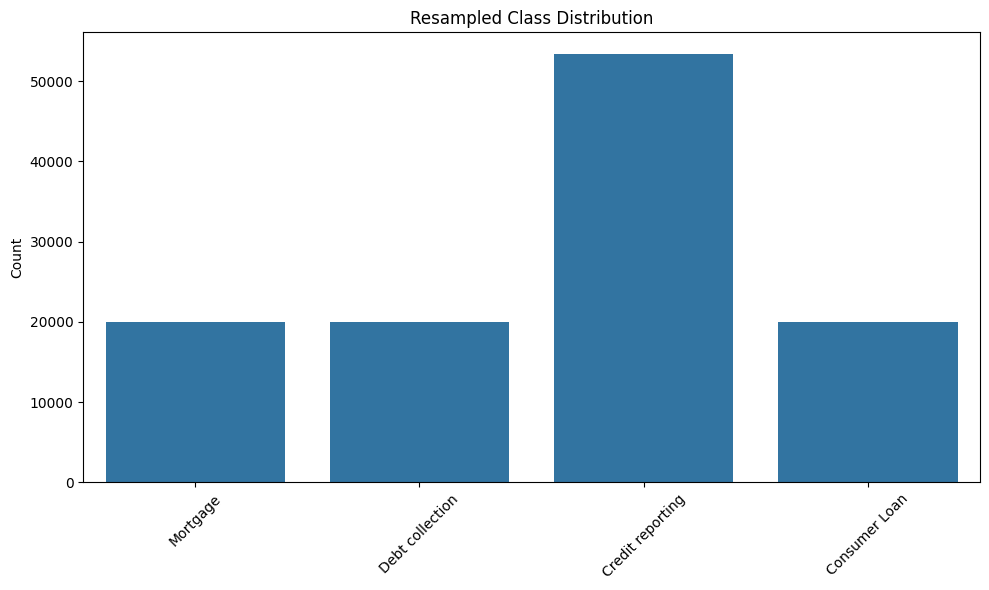


Calculating class weights...

Class Weights:
  Credit reporting: 0.5308
  Debt collection: 1.4177
  Consumer Loan: 1.4177
  Mortgage: 1.4177

Saving processed data...
Data saved to /content/drive/MyDrive/Complaints/processed/

FINAL CLASS DISTRIBUTION REPORT:
Original Distribution:
  Mortgage: 3627 (5.2%)
  Debt collection: 9320 (13.3%)
  Credit reporting: 53415 (76.3%)
  Consumer Loan: 3604 (5.2%)

Resampled Distribution:
  Mortgage: 20000 (17.6%)
  Debt collection: 20000 (17.6%)
  Credit reporting: 53415 (47.1%)
  Consumer Loan: 20000 (17.6%)

Class Weights:
  Credit reporting: 0.5308
  Debt collection: 1.4177
  Consumer Loan: 1.4177
  Mortgage: 1.4177


In [ ]:
# SUPPRESS ALL WARNINGS
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Handle class imbalance for consumer complaints
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
from scipy.sparse import load_npz, csr_matrix

# Define paths
VECTORIZED_DIR = '/content/drive/MyDrive/Complaints/'
VECTORIZED_PATH = os.path.join(VECTORIZED_DIR, 'vectorized_data.npz')

# Category mapping
category_names = {
    0: 'Credit reporting',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

def handle_class_imbalance():
    # Load vectorized data
    # Load sparse matrices
    X_train = load_npz(VECTORIZED_PATH.replace('.npz', '_X_train.npz'))
    X_test = load_npz(VECTORIZED_PATH.replace('.npz', '_X_test.npz'))

    # Load labels
    with np.load(VECTORIZED_PATH, allow_pickle=True) as data:
        y_train = data['y_train']
        y_test = data['y_test']

    # Convert to dense arrays for SMOTE
    X_train_dense = X_train.toarray()

    # 1. Report original class distribution
    original_counts = Counter(y_train)
    print("Original Class Distribution:")
    for cls, count in original_counts.items():
        print(f"  {category_names[cls]}: {count}")

    # 2. Visualize original distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[category_names[c] for c in original_counts.keys()],
                y=list(original_counts.values()))
    plt.title('Original Class Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Apply SMOTE for oversampling
    print("\nApplying SMOTE for class balancing...")
    sm = SMOTE(
        sampling_strategy={
            1: 20000,   # Debt collection
            2: 20000,   # Consumer Loan
            3: 20000    # Mortgage
        },
        k_neighbors=5,
        random_state=42
    )

    X_resampled, y_resampled = sm.fit_resample(X_train_dense, y_train)

    # 4. Report resampled distribution
    resampled_counts = Counter(y_resampled)
    print("\nResampled Class Distribution:")
    for cls, count in resampled_counts.items():
        print(f"  {category_names[cls]}: {count}")

    # 5. Visualize resampled distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[category_names[c] for c in resampled_counts.keys()],
                y=list(resampled_counts.values()))
    plt.title('Resampled Class Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6. Calculate class weights - CORRECTED METHOD
    print("\nCalculating class weights...")
    classes, counts = np.unique(y_resampled, return_counts=True)
    n_classes = len(classes)
    total_samples = np.sum(counts)

    # Standard weight calculation
    weights = total_samples / (n_classes * counts)
    weights = np.clip(weights, 0.5, 2.0)
    class_weights = {cls: weight for cls, weight in zip(classes, weights)}

    print("\nClass Weights:")
    for cls, weight in class_weights.items():
        print(f"  {category_names[cls]}: {weight:.4f}")

    # 7. Save processed data
    print("\nSaving processed data...")
    save_path = '/content/drive/MyDrive/Complaints/processed/'
    os.makedirs(save_path, exist_ok=True)

    # Save resampled data
    np.savez_compressed(
        os.path.join(save_path, 'final_train.npz'),
        X=X_resampled,
        y=y_resampled
    )

    # Save test data
    np.savez_compressed(
        os.path.join(save_path, 'test_data.npz'),
        X_test=X_test,
        y_test=y_test
    )

    # Save class weights
    joblib.dump(class_weights, os.path.join(save_path, 'class_weights.joblib'))

    print(f"Data saved to {save_path}")

    return y_train, y_resampled, class_weights

# Run imbalance handler
print("Starting class imbalance handling...")
original_y, resampled_y, class_weights = handle_class_imbalance()

# Final distribution report
print("\nFINAL CLASS DISTRIBUTION REPORT:")
print("Original Distribution:")
orig_counts = Counter(original_y)
for cls, count in orig_counts.items():
    print(f"  {category_names[cls]}: {count} ({count/len(original_y):.1%})")

print("\nResampled Distribution:")
resamp_counts = Counter(resampled_y)
for cls, count in resamp_counts.items():
    print(f"  {category_names[cls]}: {count} ({count/len(resampled_y):.1%})")

print("\nClass Weights:")
for cls, weight in class_weights.items():
    print(f"  {category_names[cls]}: {weight:.4f}")

Converting X_train from dense to sparse format
X_train type: <class 'scipy.sparse._csr.csr_matrix'>, shape: (113415, 5000)
X_test type: <class 'scipy.sparse._csr.csr_matrix'>, shape: (29986, 5000)
y_train type: <class 'numpy.ndarray'>, shape: (113415,)
y_test type: <class 'numpy.ndarray'>, shape: (29986,)
Starting model training and evaluation...

Training Logistic Regression...
Saved Logistic Regression to /content/drive/MyDrive/Complaints/models/logistic_regression.joblib

Logistic Regression Classification Report:
                  precision    recall  f1-score   support

Credit reporting     0.9731    0.8899    0.9296     22893
 Debt collection     0.6396    0.8097    0.7147      3994
   Consumer Loan     0.5740    0.8557    0.6871      1545
        Mortgage     0.8343    0.9073    0.8693      1554

        accuracy                         0.8784     29986
       macro avg     0.7553    0.8657    0.8002     29986
    weighted avg     0.9009    0.8784    0.8854     29986



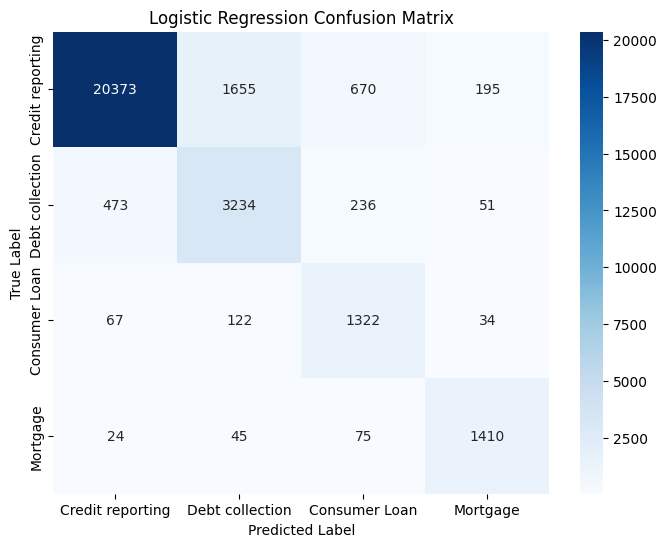


Training Random Forest...
Saved Random Forest to /content/drive/MyDrive/Complaints/models/random_forest.joblib

Random Forest Classification Report:
                  precision    recall  f1-score   support

Credit reporting     0.9455    0.9534    0.9495     22893
 Debt collection     0.7723    0.7253    0.7481      3994
   Consumer Loan     0.7183    0.7560    0.7367      1545
        Mortgage     0.8735    0.8578    0.8656      1554

        accuracy                         0.9079     29986
       macro avg     0.8274    0.8231    0.8250     29986
    weighted avg     0.9070    0.9079    0.9073     29986



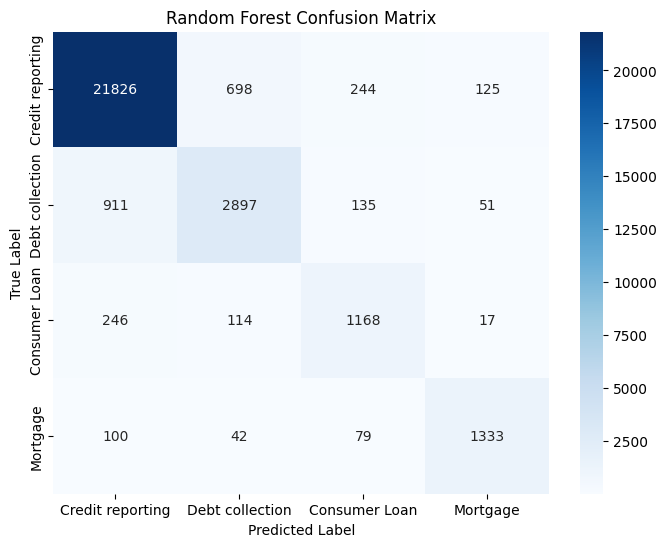


Training Linear SVM...
Saved Linear SVM to /content/drive/MyDrive/Complaints/models/linear_svm.joblib

Linear SVM Classification Report:
                  precision    recall  f1-score   support

Credit reporting     0.9573    0.9315    0.9442     22893
 Debt collection     0.7154    0.7491    0.7319      3994
   Consumer Loan     0.6423    0.8006    0.7128      1545
        Mortgage     0.8635    0.8912    0.8771      1554

        accuracy                         0.8984     29986
       macro avg     0.7946    0.8431    0.8165     29986
    weighted avg     0.9040    0.8984    0.9005     29986



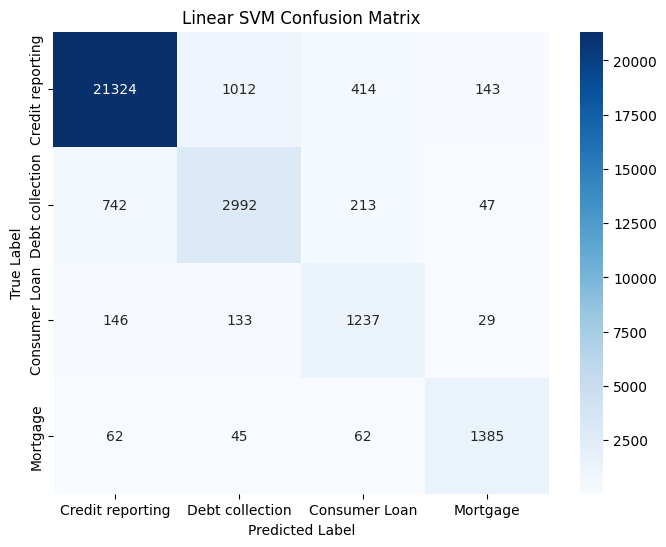


Training XGBoost...
[0]	validation_0-merror:0.13033
[50]	validation_0-merror:0.10902
[100]	validation_0-merror:0.10228
[150]	validation_0-merror:0.09815
[200]	validation_0-merror:0.09578
[250]	validation_0-merror:0.09464
[299]	validation_0-merror:0.09344
Saved XGBoost to /content/drive/MyDrive/Complaints/models/xgboost.joblib

XGBoost Classification Report:
                  precision    recall  f1-score   support

Credit reporting     0.9458    0.9504    0.9481     22893
 Debt collection     0.7599    0.7226    0.7408      3994
   Consumer Loan     0.7140    0.7676    0.7399      1545
        Mortgage     0.8903    0.8719    0.8810      1554

        accuracy                         0.9066     29986
       macro avg     0.8275    0.8281    0.8274     29986
    weighted avg     0.9062    0.9066    0.9062     29986



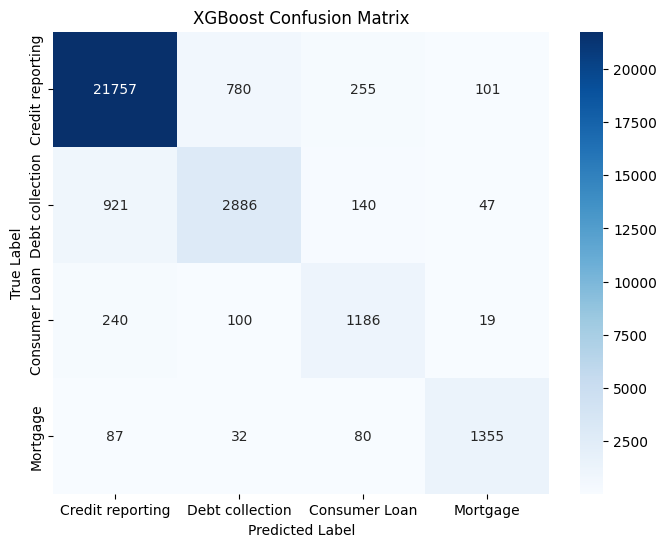



Model Performance Comparison:
                 Model  Accuracy   ROC AUC  Train Time (s)  Predict Time (s)
0  Logistic Regression  0.878377  0.965303       17.759546          0.022534
1        Random Forest  0.907890  0.969103     1019.985265          1.806195
2           Linear SVM  0.898353  0.963481       48.279935          0.081949
3              XGBoost  0.906556  0.971106    11476.318323          5.867117


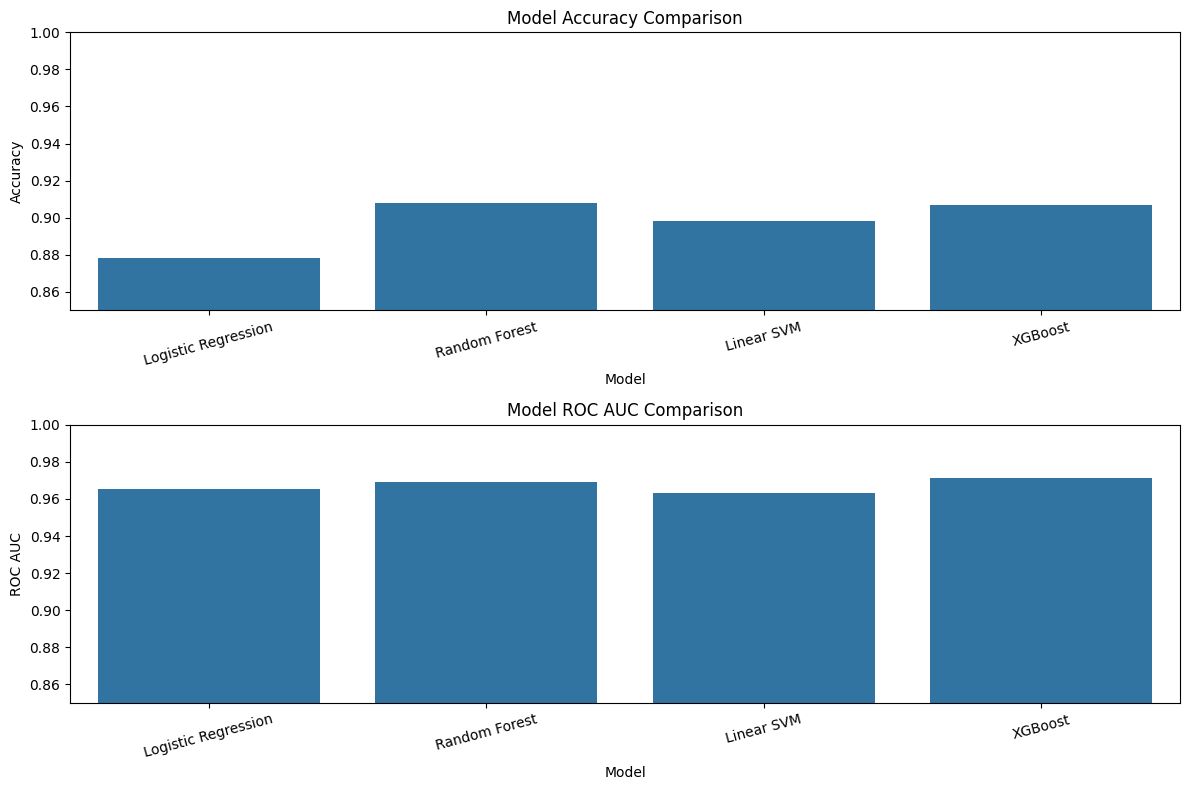


Model training and evaluation complete!

Saved best model (XGBoost) to /content/drive/MyDrive/Complaints/models/final_model.joblib


In [ ]:
# SUPPRESS ALL WARNINGS
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score
)
from sklearn.preprocessing import LabelBinarizer
import joblib
import os
from scipy.sparse import load_npz, csr_matrix, issparse

# Set paths
PROCESSED_DIR = '/content/drive/MyDrive/Complaints/processed/'
MODEL_DIR = '/content/drive/MyDrive/Complaints/models/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Category names
category_names = {
    0: 'Credit reporting',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

# Load processed data
train_data = np.load(os.path.join(PROCESSED_DIR, 'final_train.npz'), allow_pickle=True)
test_data = np.load(os.path.join(PROCESSED_DIR, 'test_data.npz'), allow_pickle=True)
class_weights = joblib.load(os.path.join(PROCESSED_DIR, 'class_weights.joblib'))

# Corrected extraction function
def extract_data(data, key):
    """Extract data from NPZ file and handle sparse matrix format"""
    item = data[key]

    # If stored as object array (scipy sparse matrix)
    if isinstance(item, np.ndarray) and item.dtype == object:
        # Extract the sparse matrix from the object array
        return item.item()

    # If already a sparse matrix
    if issparse(item):
        return item

    return item

X_train = extract_data(train_data, 'X')
y_train = extract_data(train_data, 'y')
X_test = extract_data(test_data, 'X_test')
y_test = extract_data(test_data, 'y_test')

# Verify sparse matrix format
if not issparse(X_train):
    # Attempt to convert to CSR if it's not sparse but is a numpy array
    if isinstance(X_train, np.ndarray):
        print("Converting X_train from dense to sparse format")
        X_train = csr_matrix(X_train)
    else:
        raise TypeError(f"X_train must be a sparse matrix after extraction. Got {type(X_train)}")

if not issparse(X_test):
    if isinstance(X_test, np.ndarray):
        print("Converting X_test from dense to sparse format")
        X_test = csr_matrix(X_test)
    else:
        raise TypeError(f"X_test must be a sparse matrix after extraction. Got {type(X_test)}")

print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")
print(f"y_train type: {type(y_train)}, shape: {y_train.shape}")
print(f"y_test type: {type(y_test)}, shape: {y_test.shape}")

# Initialize models with optimized parameters
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight=class_weights,
        n_jobs=-1,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    "Linear SVM": CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight=class_weights,
            max_iter=5000,
            random_state=42,
            dual=False  # Recommended for sparse data
        ),
        cv=3
    ),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        n_estimators=300,
        eval_metric='merror',
        early_stopping_rounds=20,
        n_jobs=-1,
        random_state=42,
        tree_method='hist'
    )
}

# Train and evaluate models
results = []
trained_models = {}

print("Starting model training and evaluation...\n")
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time()

    # Special handling for XGBoost
    if name == "XGBoost":
        # Train with early stopping
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=50
        )
    else:
        # Train other models normally
        model.fit(X_train, y_train)

    train_time = time() - start_time

    # Predict
    start_time = time()
    y_pred = model.predict(X_test)
    predict_time = time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Handle ROC AUC calculation
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        # For LinearSVC via CalibratedClassifierCV
        y_proba = model.predict_proba(X_test)

    roc_auc = roc_auc_score(
        LabelBinarizer().fit_transform(y_test),
        y_proba,
        multi_class='ovr'
    )

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Train Time (s)': train_time,
        'Predict Time (s)': predict_time
    })

    # Save trained model
    trained_models[name] = model
    model_path = os.path.join(MODEL_DIR, f'{name.replace(" ", "_").lower()}.joblib')
    joblib.dump(model, model_path)
    print(f"Saved {name} to {model_path}")

    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(
        y_test,
        y_pred,
        target_names=[category_names[i] for i in range(4)],
        digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=category_names.values(),
                yticklabels=category_names.values())
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("="*80 + "\n")

# Compare model performance
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0.85, 1.0)
plt.xticks(rotation=15)

plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='ROC AUC', data=results_df)
plt.title('Model ROC AUC Comparison')
plt.ylim(0.85, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Save results
results_df.to_csv(os.path.join(MODEL_DIR, 'model_comparison.csv'), index=False)
print("\nModel training and evaluation complete!")

# Select best model based on ROC AUC
best_model_name = results_df.loc[results_df['ROC AUC'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

# Save final model
final_model_path = os.path.join(MODEL_DIR, 'final_model.joblib')
joblib.dump(best_model, final_model_path)
print(f"\nSaved best model ({best_model_name}) to {final_model_path}")

In [ ]:
# Step 6: Prediction (Final Fixed Version)
import pandas as pd
import numpy as np
import re
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import load_npz
import os
import json

# Download required NLTK resources
nltk.download(['punkt', 'stopwords', 'wordnet'], quiet=True)

# PRE-COMPUTE STOPWORDS AND FINANCIAL TERMS
base_stopwords = set(stopwords.words('english'))
financial_stopwords = {'bank', 'account', 'company', 'information', 'please', 'would',
                       'could', 'also', 'said', 'one', 'two', 'like', 'even', 'get', 'since'}
full_stopwords = base_stopwords.union(financial_stopwords)

financial_mapping = {
    'mortgage': 'mortgag', 'loan': 'loan', 'credit': 'credit', 'debt': 'debt',
    'collector': 'collect', 'report': 'report', 'collection': 'collect',
    'reporting': 'report', 'reported': 'report', 'equifax': 'creditbureau',
    'experian': 'creditbureau', 'transunion': 'creditbureau'
}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
lemma_cache = {}

def get_lemma(token):
    """Cached lemmatization for faster processing"""
    if token in lemma_cache:
        return lemma_cache[token]

    lemma = lemmatizer.lemmatize(token, pos='n')
    lemma = lemmatizer.lemmatize(lemma, pos='v')
    lemma_cache[token] = lemma
    return lemma

# Optimized token pattern
token_pattern = re.compile(r'\b\w{3,}\b')  # Only words with 3+ characters

def preprocess_complaint_text(text):
    """Preprocess new complaint text"""
    if not isinstance(text, str) or len(text.strip()) < 10:
        return ""

    # Text cleaning
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = token_pattern.findall(text)

    # Process tokens
    processed_tokens = []
    for token in tokens:
        if token in full_stopwords:
            continue

        # Lemmatize with cache
        lemma = get_lemma(token)

        # Normalize financial terms
        if lemma in financial_mapping:
            lemma = financial_mapping[lemma]

        processed_tokens.append(lemma)

    return ' '.join(processed_tokens)

# Path configuration
MODEL_PATH = '/content/drive/MyDrive/Complaints/models/final_model.joblib'
VECTORIZER_PATH = '/content/drive/MyDrive/Complaints/tfidf_vectorizer.joblib'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# Load the model
model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

# Reconstruct vectorizer from available files
def reconstruct_vectorizer(vectorized_path):
    """Reconstruct TF-IDF vectorizer from vectorized data"""
    # Get feature names if available
    feature_names_path = vectorized_path.replace('.npz', '_feature_names.npy')
    vocab_path = vectorized_path.replace('.npz', '_vocab.json')
    idf_path = vectorized_path.replace('.npz', '_idf.npy')

    # Load the vectorized data to get feature count
    X_train = load_npz(vectorized_path.replace('.npz', '_X_train.npz'))
    n_features = X_train.shape[1]

    # Create vectorizer with correct parameters
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        dtype=np.float32
    )

    # Try to load actual vocabulary
    if os.path.exists(vocab_path):
        with open(vocab_path, 'r') as f:
            vocab = json.load(f)
        print("Loaded actual vocabulary")
    else:
        # Create dummy vocabulary
        vocab = {f"feature_{i}": i for i in range(n_features)}
        print("Warning: Using dummy vocabulary (accuracy may be affected)")

    # Try to load actual IDF values
    if os.path.exists(idf_path):
        idf_vector = np.load(idf_path)
        print("Loaded actual IDF values")
    else:
        # Create dummy IDF values
        idf_vector = np.ones(n_features)
        print("Warning: Using dummy IDF values (accuracy may be affected)")

    # Set up vectorizer
    vectorizer.vocabulary_ = vocab
    vectorizer.fixed_vocabulary_ = True
    vectorizer.idf_ = idf_vector

    # Set feature names if available
    if os.path.exists(feature_names_path):
        feature_names = np.load(feature_names_path, allow_pickle=True)
        vectorizer.feature_names_out_ = feature_names
        print(f"Loaded {len(feature_names)} feature names")
    else:
        # Create dummy feature names
        feature_names = [f"feature_{i}" for i in range(n_features)]
        vectorizer.feature_names_out_ = np.array(feature_names)
        print(f"Created {len(feature_names)} dummy feature names")

    return vectorizer

# Reconstruct vectorizer
print("Reconstructing vectorizer...")
vectorizer = reconstruct_vectorizer(VECTORIZED_PATH)
print(f"Successfully reconstructed vectorizer with {len(vectorizer.get_feature_names_out())} features")

# Category mapping
category_names = {
    0: 'Credit reporting, repair, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

def predict_complaint(complaint_text):
    """Predict category for a new complaint"""
    # Preprocess text
    clean_text = preprocess_complaint_text(complaint_text)

    # Vectorize text
    text_vector = vectorizer.transform([clean_text])

    # Make prediction
    prediction = model.predict(text_vector)

    # Get probabilities if available
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(text_vector)[0]
    else:
        # Handle models without probability estimates
        probabilities = [0.0] * len(category_names)
        probabilities[prediction[0]] = 1.0

    # Get results
    category_num = prediction[0]
    category_name = category_names[category_num]
    confidence = probabilities[category_num]

    # Format probabilities
    prob_details = {category_names[i]: f"{prob:.4f}" for i, prob in enumerate(probabilities)}

    return {
        'category': category_name,
        'confidence': confidence,
        'probabilities': prob_details,
        'clean_text': clean_text
    }

# ======================================
# Example Usage
# ======================================

# Sample complaint texts
sample_complaints = [
    "I've been receiving constant calls from debt collectors about a medical bill from 2019 that I've already paid. They're harassing me daily!",
    "There's an error on my credit report showing a late payment from XYZ Bank that I never made. This is damaging my credit score unfairly.",
    "My mortgage lender rejected my refinancing application without proper explanation even though I have perfect payment history.",
    "The car loan company charged me excessive fees when I tried to pay off my auto loan early last month.",
    "Equifax and TransUnion both have incorrect personal information in my credit file that I've tried to dispute multiple times with no resolution.",
    "A debt collection agency is trying to collect on a payday loan that's past the statute of limitations in my state.",
    "My mortgage servicer miscalculated my escrow account and now claims I owe thousands more than I actually do.",
    "The personal loan I took out has hidden fees that weren't disclosed in the original agreement."
]

# Make predictions
print("="*50)
print("COMPLAINT CLASSIFICATION RESULTS")
print("="*50)

for i, complaint in enumerate(sample_complaints, 1):
    result = predict_complaint(complaint)

    print(f"\nComplaint #{i}:")
    print(f"Original Text: {complaint[:150]}...")
    print(f"Cleaned Text: {result['clean_text'][:150]}...")
    print(f"Predicted Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("Probability Distribution:")
    for cat, prob in result['probabilities'].items():
        print(f"  {cat}: {prob}")
    print("-"*50)

Reconstructing vectorizer...
Created 5000 dummy feature names
Successfully reconstructed vectorizer with 5000 features
COMPLAINT CLASSIFICATION RESULTS

Complaint #1:
Original Text: I've been receiving constant calls from debt collectors about a medical bill from 2019 that I've already paid. They're harassing me daily!...
Cleaned Text: ive receive constant call debt collect medical bill ive already pay theyre harass daily...
Predicted Category: Credit reporting, repair, or other
Confidence: 0.6761
Probability Distribution:
  Credit reporting, repair, or other: 0.6761
  Debt collection: 0.2618
  Consumer Loan: 0.0468
  Mortgage: 0.0153
--------------------------------------------------

Complaint #2:
Original Text: There's an error on my credit report showing a late payment from XYZ Bank that I never made. This is damaging my credit score unfairly....
Cleaned Text: there error credit report show late payment xyz never make damage credit score unfairly...
Predicted Category: Credit repor